In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# PART 1 (ProcessDicom)
# dataset_dir = "/home/rodrigo/processed-dataset/"
# zip_list = glob(dataset_dir + "*.zip")
# extract_dicom_zips(zip_list)

# PART 2 (ChooseBestScans)
# root_dir = '/home/rodrigo/processed-dataset/'
# exam_dirs = get_exam_dirs(root_dir)
# exams_dictionary = gen_exams_dictionay(exam_dirs)
# best_scans_dict = check_best_scan(exams_dictionary)
# save_best_scans(root_dir, best_scans_dict)

# PART 3 (ExtractDicom)
# root_dir = '/home/rodrigo/processed-dataset/'
# good_scans = root_dir + 'GoodDirs.txt'
# order_all_series(good_scans)
# gen_all_pngs(root_dir) -> RETIRAR

# PART 4 (ProcessImages)
# dataset_dir = "/home/rodrigo/processed-dataset/"
# dir_list = glob(dataset_dir + "[0-9]*")
# total = len(dir_list)
#
# complete = 1
# for exam_dir in dir_list:
#     print("processing exam " + os.path.basename(exam_dir))
#     image_dir = exam_dir + "/pngs" -> MUDAR PARA PEGAR DICOMS E FAZER JANELAMENTO
#     filelist = os.listdir(image_dir)
#     process_exam(filelist, image_dir)
#     print(str(complete) + "/" + str(total))
#     complete += 1

# PART 5 (PrepareTrainingData)
# root_dir = "/home/rodrigo/processed-dataset/"
# chosen_scans = root_dir + "GoodDirs.txt"
# labels_file = root_dir + "labels-batch.csv"
#
# serie_list = read_serie_paths(chosen_scans)
# labels = read_labels(labels_file)
# save_slices_labels(serie_list, labels)


# PART 6 (Model)

# Import Required Libraries

In [3]:
import os
import cv2
import gdcm
import numpy as np
import pydicom
import scipy
from matplotlib import pyplot, image
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import ndimage
from glob import glob
pyplot.style.use('dark_background')

# Read and Plot Functions 

In [4]:
# PEGAR DICOM E NAO PNG PARA FAZER O JANELAMENTO
def read_image(filepath):
    # Read grayscale DICOM image
    image = cv2.imread(filepath)
    return image

def generate_histogram(image):
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    return histogram

def save_processed_image(img, directory, filename):
    processed_filepath = directory + 'p-' + filename
    cv2.imwrite(processed_filepath, img)

def save_histogram(histogram, h_directory, filename):
    pyplot.figure(figsize=(2,2))
    pyplot.xlim([0, 250])
    pyplot.ylim([0, 400])
    pyplot.axis('off')
    pyplot.plot(histogram)
    pyplot.savefig(h_directory + "h-" + filename, bbox_inches=0)
    pyplot.close()

In [5]:
def plot_image(image):
    imgplot = pyplot.imshow(image, cmap=pyplot.cm.bone)
    
def plot_histogram(histogram):
    # configure and draw the histogram figure
    pyplot.figure()
    pyplot.title("CT-Scan Histogram")
    pyplot.xlabel("grayscale value")
    pyplot.ylabel("pixels")
    pyplot.xlim([0, 256])
    # TODO: qual será o limite de y?
    pyplot.ylim([0, 400])
    pyplot.plot(histogram)
    pyplot.show()

# Windowing

In [6]:
def window_exam(dicom_dir):
    filenames_and_images = []
    for dcm_path in glob(dicom_dir + "/*.dcm"):
        filename = os.path.splitext(os.path.basename(dcm_path))[0]
        # READ DICOM
        dcm_data = pydicom.read_file(dcm_path)
        img = dcm_data.pixel_array
        # SCALE DICOM AND TRANSFORM TO HU
        xsize = 224; ysize = 224
        dcm_hu = dcm_to_hu_224(dcm_path, xsize, ysize)
        # create image with correct channel
        final_window = create_channel(dcm_hu, 40, 100)
        # remove skull using windowing
        img_no_skull = remove_skull(dcm_hu, final_window)
        filenames_and_images.append((filename, img_no_skull))
    return filenames_and_images

def remove_skull(dcm_hu, final_window):
    bone_mask = create_channel(dcm_hu, 80, 80)
    ret, thresh = cv2.threshold(bone_mask, 245, 256, 0)
    image = final_window - thresh
    return image

def process_slice(dcm_path):
    image = dcm_to_hu_224(dcm_path)
    return stack_channels(image)

def dcm_to_hu_224(dcm_path, xsize, ysize):
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    data = get_hu_values(dcm_data)
    xscale = xsize/img.shape[0]; yscale = ysize/img.shape[1]
    return scipy.ndimage.interpolation.zoom(data, [xscale, yscale])

def get_hu_values(dcm_data):
    slope = float(dcm_data.RescaleSlope)
    intercept = float(dcm_data.RescaleIntercept)
    matrix = np.array(dcm_data.pixel_array)
    matrix = np.multiply(matrix, slope)
    matrix = np.add(matrix, intercept)
    return matrix

def create_channel(data, level, width):
    normalized = np.piecewise(data, [data <= (level -0.5 - (width - 1) / 2), data > (level - 0.5 + (width - 1) / 2)],
                                    [0, 255, lambda data: ((data - (level - 0.5)) / (width - 1) + 0.5) * (255 - 0)])
    return cv2.convertScaleAbs(normalized)

# Image Processing Functions 

In [12]:
# Remove ventricle pixels
def remove_ventricles(img):
    img[np.where((img <= 100).all(axis = 1))] = 0
    return img

def median_filter(img):
    img = ndimage.median_filter(img, 3)
    return img

# Returns image biggest_contour and mask
def find_biggest_contour(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    if contour_sizes == []: 
        biggest_contour = np.array([[0, 0]])
    else:
        biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask 

# Remove soft tissues using biggest contour
def remove_soft_tissues(img):
    biggest_contour, mask = find_biggest_contour(img)
    biggest_contour_image = np.bitwise_and(img, mask, mask)
    return biggest_contour_image, img

# use threshold to isolate likely areas of bleeding
def isolate_hemorrhages(img):
    ret2, thresh = cv2.threshold(img, 140, 253, cv2.THRESH_BINARY)
    final_image = np.bitwise_and(img, thresh, thresh)
    return final_image

def process_exam_after_windowing(exam_dir, filenames_and_images):
    processed_dir = exam_dir + "/processed"
    for (filename, image) in filenames_and_images:
        img_no_ventricles = remove_ventricles(image)
        img_median_filter = median_filter(img_no_ventricles)
        img_no_soft_tissues, imgray = remove_soft_tissues(img_median_filter)
        final_img = isolate_hemorrhages(img_no_soft_tissues)
        processed_filepath = processed_dir + filename
        cv2.imwrite(processed_filepath, final_img)
    

In [13]:
## windowing
dcm_path = "/home/rodrigo/samples-tcc/110/dicoms/CT14.dcm"
dcm_data = pydicom.read_file(dcm_path)
img = dcm_data.pixel_array
xsize = 224; ysize = 224
dcm_hu = dcm_to_hu_224(dcm_path, xsize, ysize)
final_window = create_channel(dcm_hu, 40, 100)
image = remove_skull(dcm_hu, final_window)
print(image.shape)
### image processing
img_no_ventricles = remove_ventricles(image)
img_median_filter = median_filter(img_no_ventricles)
img_no_soft_tissues, imgray = remove_soft_tissues(img_median_filter)
final_img = isolate_hemorrhages(img_no_soft_tissues)

(224, 224)


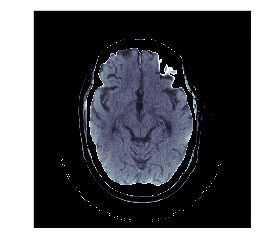

In [14]:
plot_image(image)

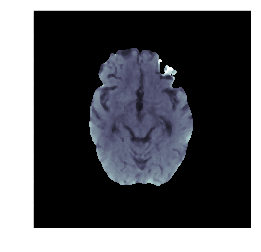

In [15]:
plot_image(img_no_soft_tissues)

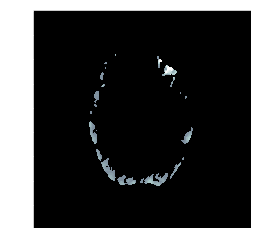

In [16]:
plot_image(final_img)

# Process Images & Save Files

In [ ]:
# dataset_dir = "/home/rodrigo/samples-tcc/"
# dir_list = glob(dataset_dir + "[0-9]*")
# total = len(dir_list)
# complete = 1

# for exam_dir in dir_list:
#     print("processing exam " + os.path.basename(exam_dir))
#     # old: image_dir = exam_dir + "/pngs"
#     dicom_dir = exam_dir + "/dicoms"
#     # old: filelist = os.listdir(image_dir)
#     # windowing
#     paths_and_images = window_exam(dicom_dir)
#     process_exam_after_windowing(exam_dir, paths_and_images)
#     # old: process_exam(filelist, image_dir)
#     print(str(complete) + "/" + str(total))
#     complete += 1

# Check Processing Step by Step

In [ ]:
# img = read_image('/home/rodrigo/Batch/159/pngs/CT11.png')
# plot_image(img)

In [ ]:
# img_no_skull = remove_skull_and_ventricles(img)
# plot_image(img_no_skull)

In [ ]:
# img_median_filter = median_filter(img_no_skull)
# plot_image(img_median_filter)

In [ ]:
# img_no_soft_tissues, imgray = remove_soft_tissues(img_median_filter)
# print(img_no_soft_tissues.shape)
# plot_image(img_no_soft_tissues)

In [ ]:
# final_img = isolate_hemorrhages(img_no_soft_tissues)
# plot_image(final_img)

In [ ]:
# OOOOOOOOOLD
# def process_file(filename, directory):
#     img = read_image(directory + "/" + filename)
#     img_no_skull = remove_skull_and_ventricles(img)
#     img_median_filter = median_filter(img_no_skull)
#     img_no_soft_tissues, imgray = remove_soft_tissues(img_median_filter)
#     final_img = isolate_hemorrhages(img_no_soft_tissues)
#     return final_img

# def process_exam(filelist, i_dir):
#     # i_dir = /home/dataset/1/pngs
#     exam_dir = os.path.normpath(i_dir + os.sep + os.pardir)
#     p_dir = exam_dir + "/processed/"
#     h_dir = exam_dir + "/histograms/"
#     os.makedirs(p_dir, exist_ok=True)  
#     os.makedirs(h_dir, exist_ok=True)
#     for filename in filelist:
#         if ".png" in filename:
#             processed = process_file(filename, i_dir)
#             save_histogram(generate_histogram(processed), h_dir, filename)
#             save_processed_image(processed, p_dir, filename)